# Evaluation of COSMO testruns with ERA5: bias maps

end-product: maps (COSMO, ERA5 and difference) for  variable and  metric 

In [1]:
import valenspy as vp
from valenspy.preprocessing_tasks.regrid import remap_cdo
from valenspy.preprocessing_tasks.select import select_region

from valenspy.diagnostic_visualizations import *

import warnings
import xarray as xr

# Turn off all warnings
warnings.filterwarnings('ignore')

### 0. Settings

In [2]:
# define machine name - used for paths of (observational) datasets
machine = 'hortense'

# reference dataset to compare to
model = 'CCLM'

#variables =  [ 'LHFL_S', 'SHFL_S', 'PS', 'PMSL', 'T_2M', 'TOT_PREC', 'TQR', 'TQV', 'TQC', 'TQI', 'TQG', 'TQS', 'CLCT', 'CLCL','CLCM','CLCH', 'QV_S', 'T_S',  'QV_S']

In [3]:
# directory with experiments

experiments = ["EUR11_CO_TA_GC_TSO",
               "EUR11_CO_TE_GC_TSO", 
               "EUR11_CO_TT_GC_TSO", 
               "EUR11_CO_TT_EC_TSO", 
               "EUR11_NU_TE_GC_TSO", 
               "EUR11_NU_TT_GC_TSO", 
               "EUR11_NU_TT_EC_TSO"]

experiments = ["EUR11_CO_TA_GC_TSO"]


In [4]:
def load_calc_plot_bias_map(variable: str, ref_dataset: str, experiments: list, months_to_analyse: list, region='europe', freq='hourly'): 

    # ------------------------------
    # 1. Load reference data - works for ERA5, CLIMATE_GRID and EOBS

    # start up input manager
    manager = vp.InputManager(machine=machine)

    if ref_dataset == 'ERA5' or ref_dataset== 'ERA5-Land':

        if variable == 'tasmax':        
            ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq="hourly",region='europe')
            ds_obs = ds_obs.resample(time='1D').max().rename({'tas':variable})


        elif variable == "tasmin": 

            ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq="hourly",region='europe')
            ds_obs = ds_obs.resample(time='1D').min().rename({'tas':variable}) 

        else: 
            ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq=freq,region='europe')

            if freq == "hourly": 
                ds_obs = ds_obs.resample(time='1D').mean()    

        # retrieve ERA5 gridfile - for regridding 
        gridfile = manager._get_file_paths(ref_dataset,variable, period=[1995,1995],freq=freq,region='europe')[0]
            
    elif ref_dataset == 'CLIMATE_GRID': 

        # use input manager to load data, defined on settings abov
        ds_obs = manager.load_data(ref_dataset,variable, path_identifiers=['latlon_5km'])

        # select corresponding year
        ds_obs = ds_obs.sel(time = ds_obs.time.dt.year.isin(1995))

        # retrieve ERA5 gridfile - for regridding 
        gridfile = manager._get_file_paths(ref_dataset,variable, path_identifiers=['latlon_5km'])[0]
        region = 'belgium'

    elif ref_dataset=='EOBS': 

        # use input manager to load data, defined on settings abov
        ds_obs = manager.load_data(ref_dataset,variable, path_identifiers=['0.1deg', 'mean'])
        ds_obs = ds_obs.sel(time = ds_obs.time.dt.year.isin(1995))

        # retrieve ERA5 gridfile - for regridding 
        gridfile = manager._get_file_paths(ref_dataset,variable, path_identifiers=['0.1deg', 'mean'])[0]

    
    # ------------------------------
    # 2. Load and regrid model data

    for experiment in experiments: 

        print(experiment)

        # define the CCLM files for the corresponding variable
        if variable == "tasmax": 
            daily_statistic = "max"

        elif variable == "tasmin": 
            daily_statistic = "min"

        else: 
            daily_statistic = "mean"
        
        # load data
        ds_mod = manager.load_data(model, [variable], freq="daily", path_identifiers=[experiment, daily_statistic])


        # ------------------------------
        # 3. Preprocessing: remapping and selection
            
        ds_mod = remap_cdo(gridfile, ds_mod, remap_method = "con")

        # do spatial selection
        ds_mod = select_region(ds_mod, region=region)
        ds_obs = select_region(ds_obs, region=region)

        # select variable and corresponding period
        da_mod = ds_mod[variable].sel(time=ds_mod['time'].dt.month.isin(months_to_analyse))
        da_obs = ds_obs[variable].sel(time=ds_obs['time'].dt.month.isin(months_to_analyse))


        da_mod = da_mod.mean('time')
        da_mod.attrs['dataset'] = experiment
        da_obs = da_obs.mean('time')
        da_diff = da_mod - da_obs
        
        ax = plot_maps_mod_ref_diff(da_mod,  da_obs,  da_diff, region=region)


### 2 m temperature

#### ERA 5 

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/2m_temperature/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
EUR11_CO_TA_GC_TSO
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
CPU times: user 27.7 s, sys: 7.29 s, total: 35 s
Wall time: 59.3 s


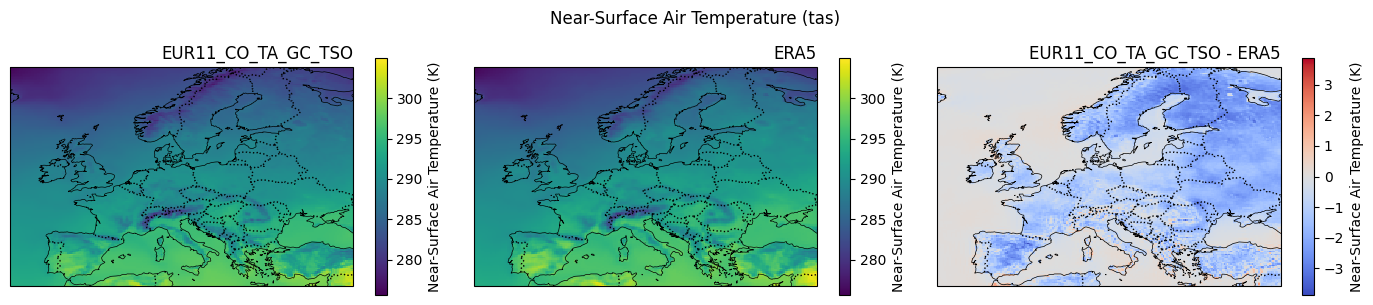

In [5]:
%%time

region = 'europe'
variable = 'tas'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)



File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/2m_temperature/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
EUR11_CO_TA_GC_TSO
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
CPU times: user 25.5 s, sys: 6.33 s, total: 31.9 s
Wall time: 35.5 s


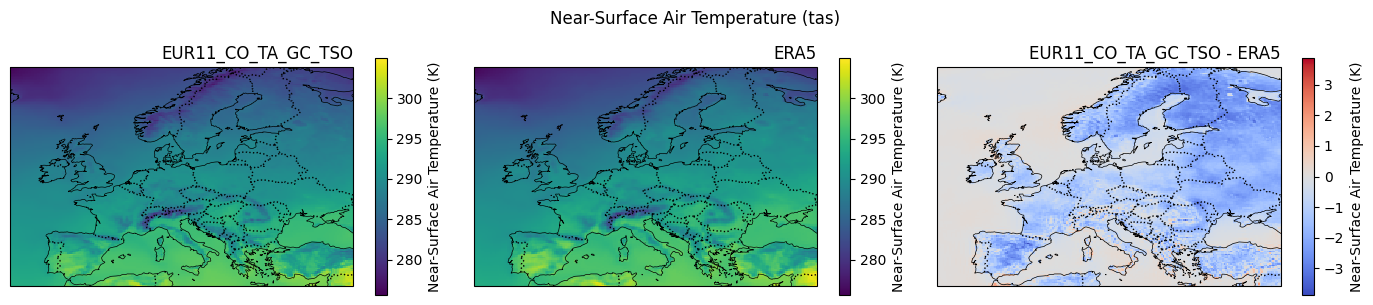

In [6]:
%%time

region = 'europe'
variable = 'tas'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)



File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/2m_temperature/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
EUR11_CO_TA_GC_TSO
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']


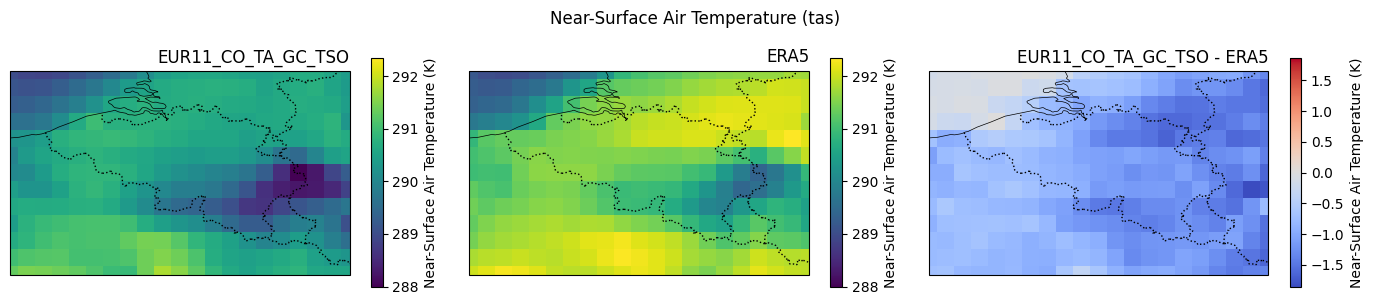

In [7]:
region = 'belgium'
variable = 'tas'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)



#### EOBS

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/EOBS/0.1deg/tg_ens_mean_0.1deg_reg_v29.0e.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
EUR11_CO_TA_GC_TSO
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']


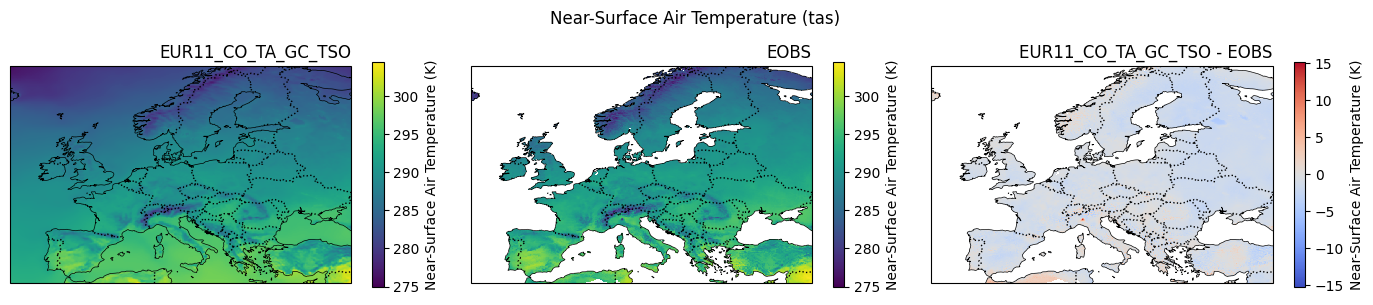

In [8]:
region = 'europe'
variable = 'tas'
ref_dataset = "EOBS"
months_to_analyse = [6,7,8]
fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)



File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/EOBS/0.1deg/tg_ens_mean_0.1deg_reg_v29.0e.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
EUR11_CO_TA_GC_TSO
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']


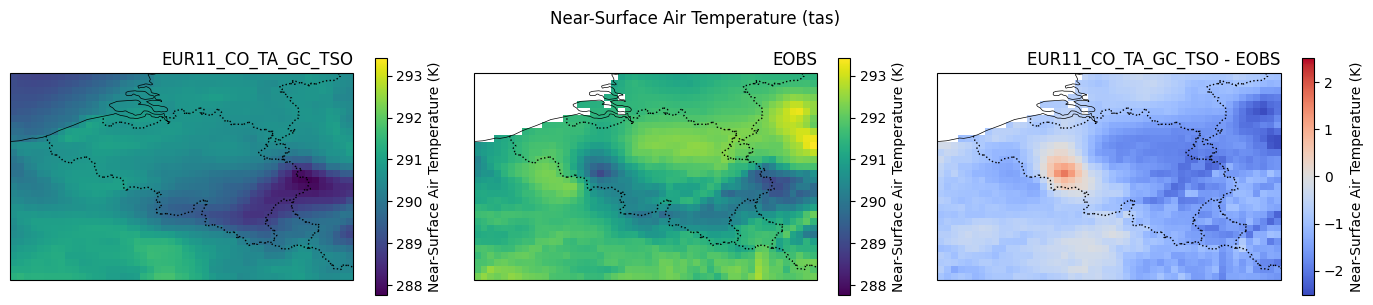

In [11]:
region = 'belgium'
variable = 'tas'
ref_dataset = "EOBS"
months_to_analyse = [6,7,8]
fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)



#### CLIMATE_GRID

File paths found:
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc31332_inne/CLIMATE_GRID/regridded/latlon_5km/TEMP_AVG_CLIMATE_GRID_1954_2023_daily_latlon_5km.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
EUR11_CO_TA_GC_TSO


File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']


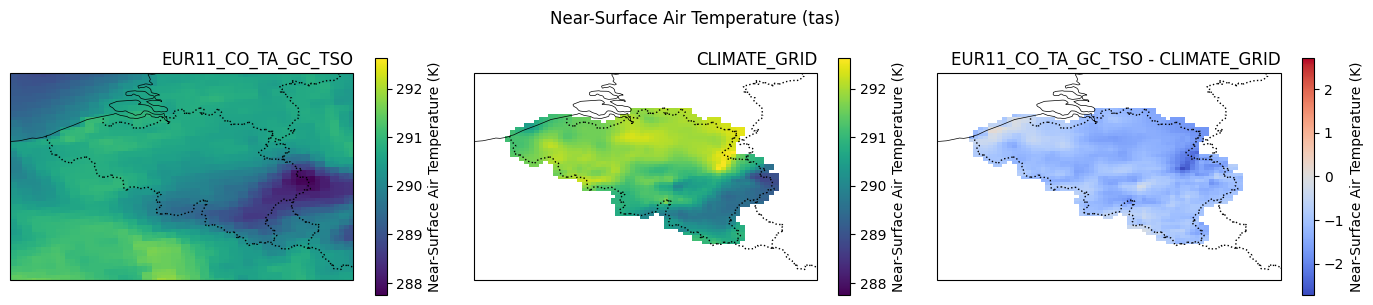

In [12]:
region = 'belgium'
variable = 'tas'
ref_dataset = "CLIMATE_GRID"
months_to_analyse = [6,7,8]
fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)


### Maxmimum 2m temperature

#### ERA5

In [13]:
region = 'europe'
variable = 'tasmax'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)


FileNotFoundError: No files found for dataset ERA5, variables tasmax, period [1995, 1995], frequency hourly, region europe and path_identifiers [].

#### CLIMATE_GRID

File paths found:
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc31332_inne/CLIMATE_GRID/regridded/latlon_5km/TEMP_MAX_CLIMATE_GRID_1954_2023_daily_latlon_5km.nc


The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tasmax']
EUR11_CO_TA_GC_TSO


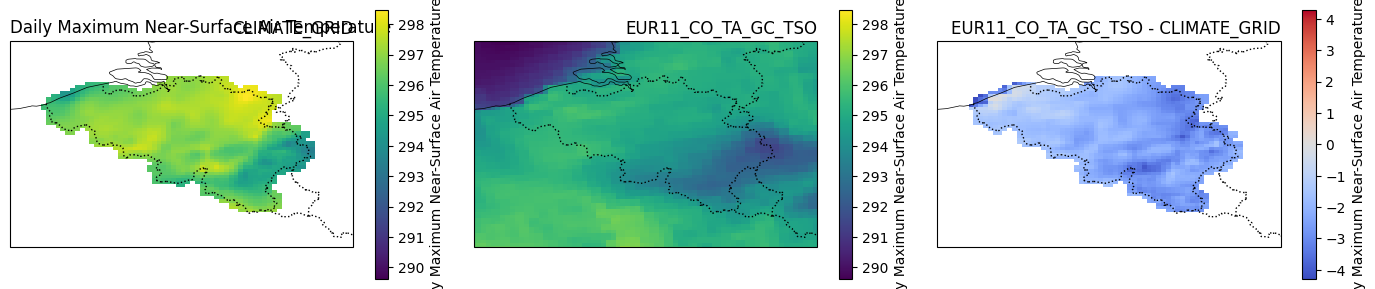

EUR11_CO_TE_GC_TSO


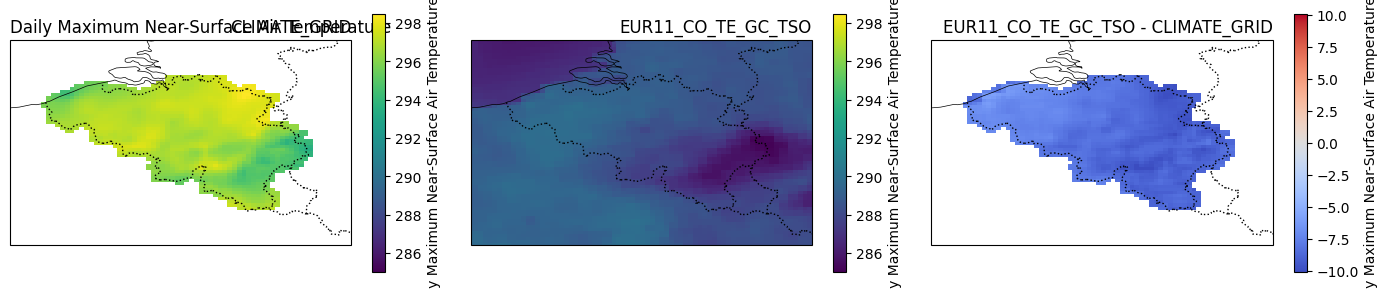

EUR11_CO_TT_GC_TSO


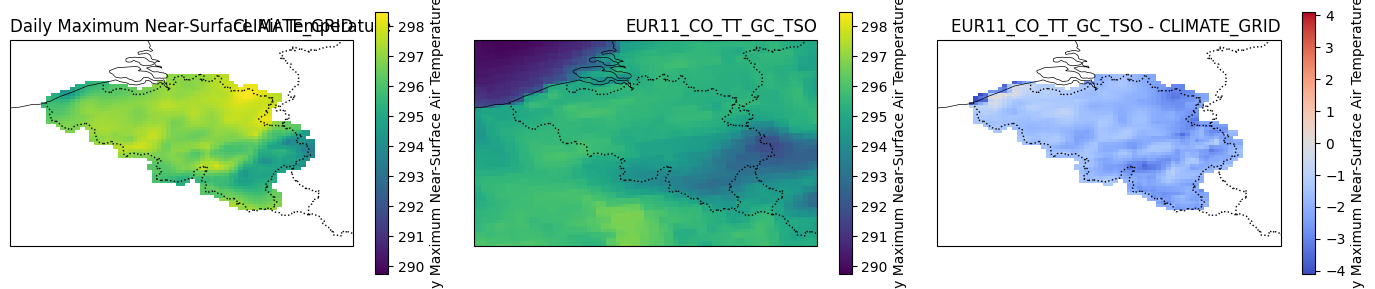

EUR11_CO_TT_EC_TSO


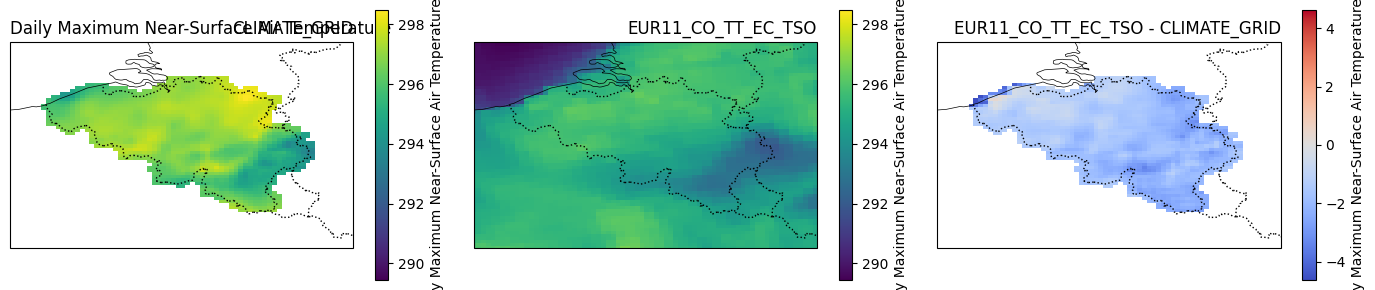

EUR11_NU_TE_GC_TSO


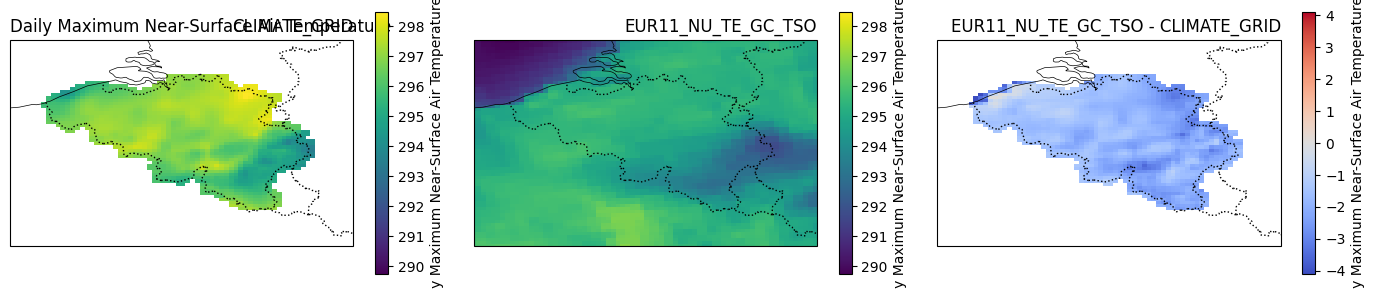

EUR11_NU_TT_GC_TSO


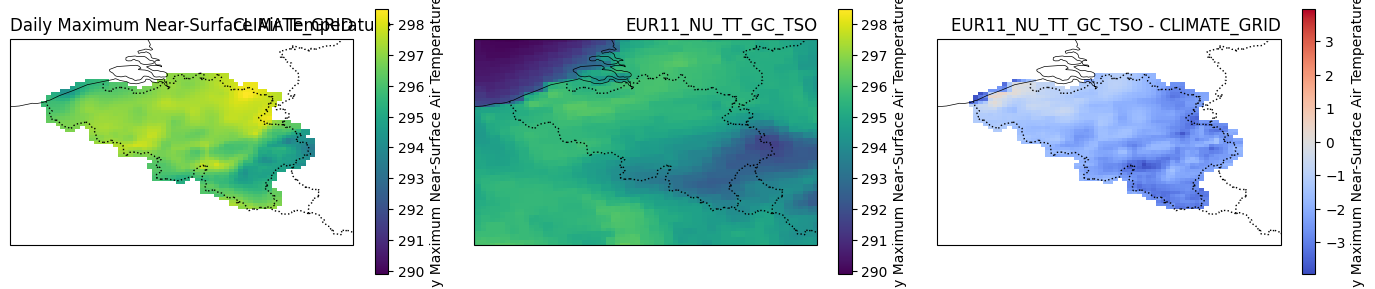

EUR11_NU_TT_EC_TSO


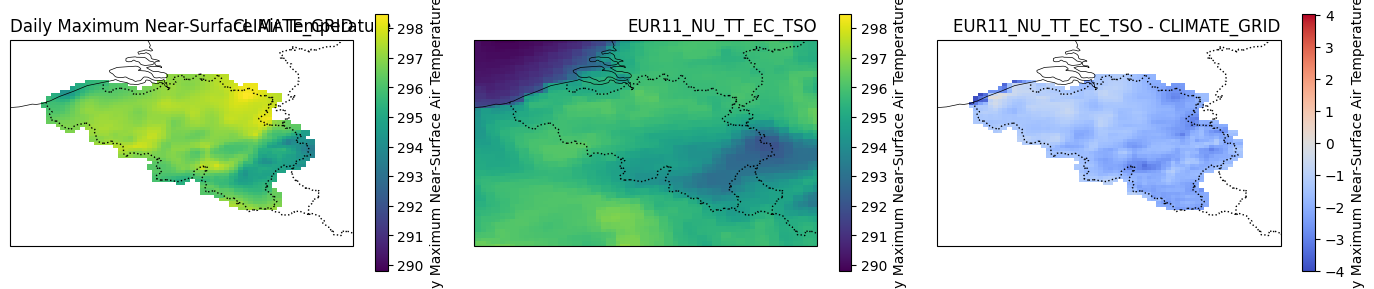

In [ ]:
region = 'belgium'
variable = 'tasmax'
ref_dataset = "CLIMATE_GRID"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)


## surface temperature

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/skin_temperature/era5-land-hourly-belgium-skin_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['ts']
EUR11_CO_TA_GC_TSO
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/T_S/daily/T_S_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['ts']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']


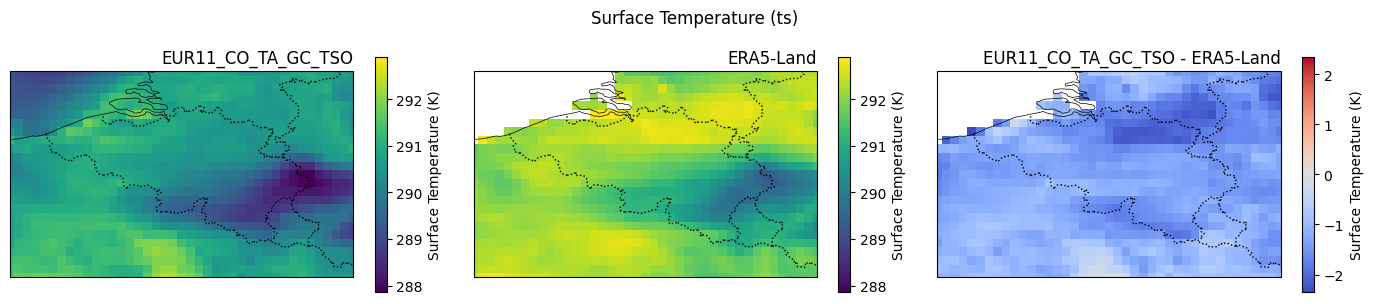

In [ ]:
region = 'belgium'
variable = 'ts'
ref_dataset = "ERA5-Land"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/2m_temperature/era5-land-hourly-belgium-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
EUR11_CO_TA_GC_TSO
cdo    remapbil: Bilinear weights from curvilinear (446x434) to lonlat (41x25) grid


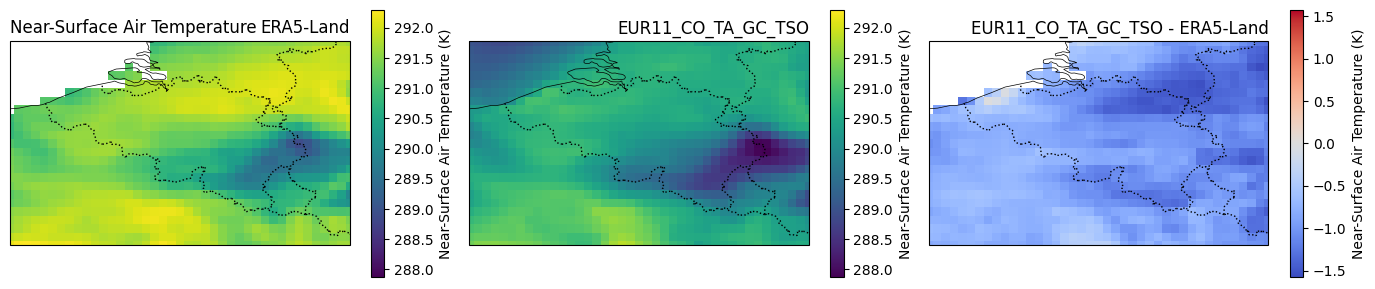

In [ ]:
region = 'belgium'
variable = 'tas'
ref_dataset = "ERA5-Land"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)


## Precipitation

@ Fien: check unit conversion in ERA5!

In [ ]:
region = 'europe'
variable = 'pr'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]


fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/total_precipitation/era5-hourly-europe-total_precipitation-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['pr']
EUR11_CO_TA_GC_TSO
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/TOT_PREC/daily/TOT_PREC_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole', 'TOT_PREC']


KeyError: "No variable named 'pr'. Variables on the dataset include ['time', 'time_bnds', 'lon', 'lat', 'TOT_PREC']"

## Cloudiness

### total cloud percentage

In [5]:
region = 'belgium'
variable = 'clt'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments, months_to_analyse, region)


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/belgium/hourly/total_cloud_cover/era5-hourly-belgium-total_cloud_cover-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['clt']
EUR11_CO_TA_GC_TSO
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/CLCT_AV/daily/CLCT_AV_daymean.nc
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/CLCT/daily/CLCT_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
25.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['clt']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole', 'CLCT_AV']


ValueError: When encoding chunked arrays of datetime values, both the units and dtype must be prescribed or both must be unprescribed. Prescribing only one or the other is not currently supported. Got a units encoding of seconds since 1995-05-01T00:00:00Z and a dtype encoding of None.

### low  cloud percentage

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/low_cloud_cover/era5-hourly-europe-low_cloud_cover-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['cll']
EUR11_CO_TA_GC_TSO
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/CLCL/daily/CLCL_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['cll']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']


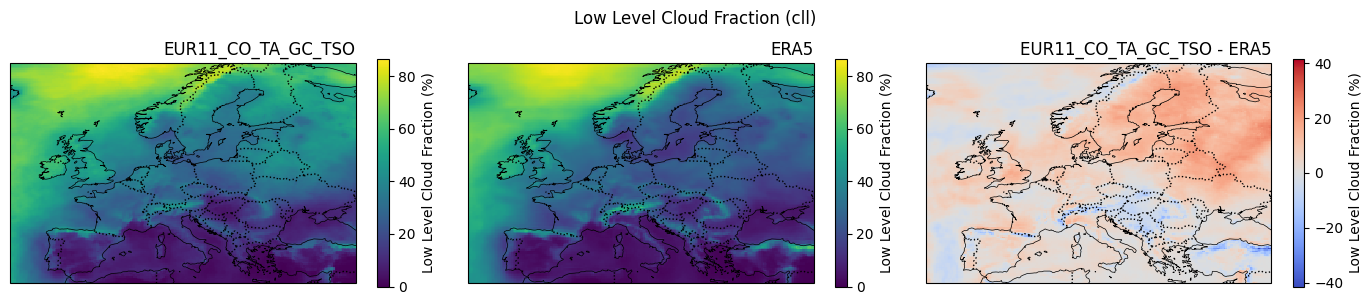

In [6]:
mod_variable = "CLCL"

region = 'europe'
variable = 'cll'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/low_cloud_cover/era5-hourly-europe-low_cloud_cover-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['cll']
EUR11_CO_TA_GC_TSO
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/CLCL/daily/CLCL_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['cll']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']


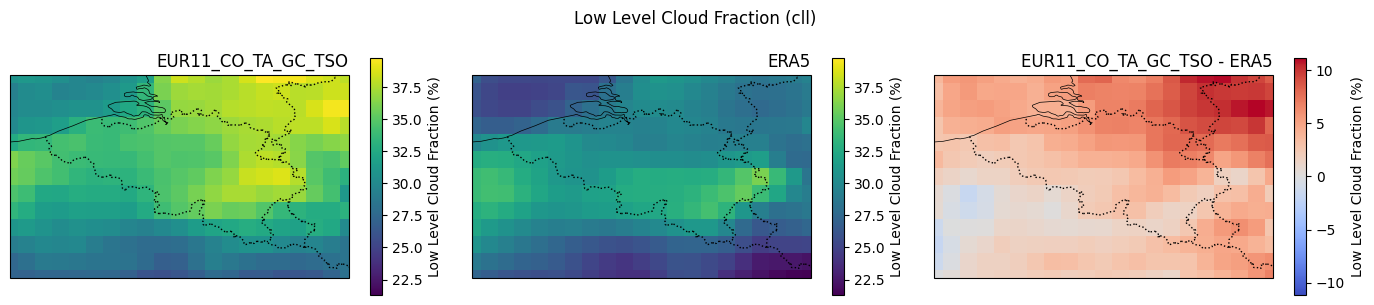

In [14]:
mod_variable = "CLCL"

region = 'belgium'
variable = 'cll'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)


### medium  cloud percentage

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/medium_cloud_cover/era5-hourly-europe-medium_cloud_cover-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['clm']


EUR11_CO_TA_GC_TSO
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/CLCM/daily/CLCM_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['clm']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']


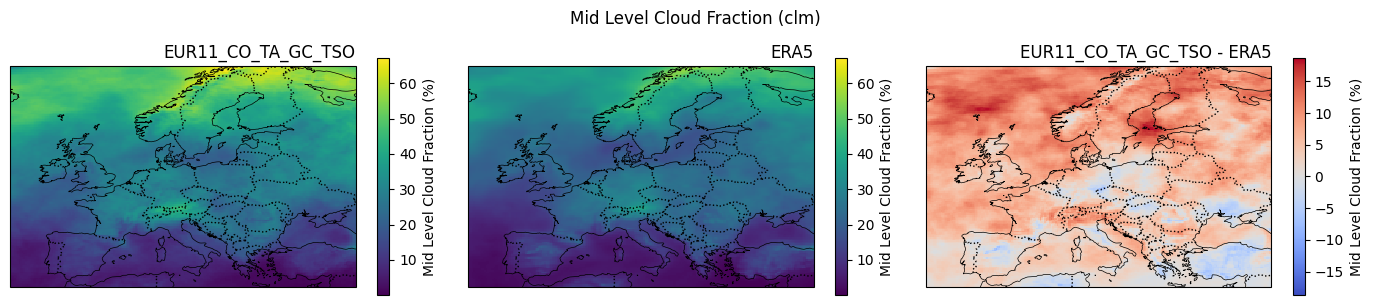

In [9]:
mod_variable = "CLCM"

region = 'europe'
variable = 'clm'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/medium_cloud_cover/era5-hourly-europe-medium_cloud_cover-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['clm']
EUR11_CO_TA_GC_TSO
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/CLCM/daily/CLCM_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['clm']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']


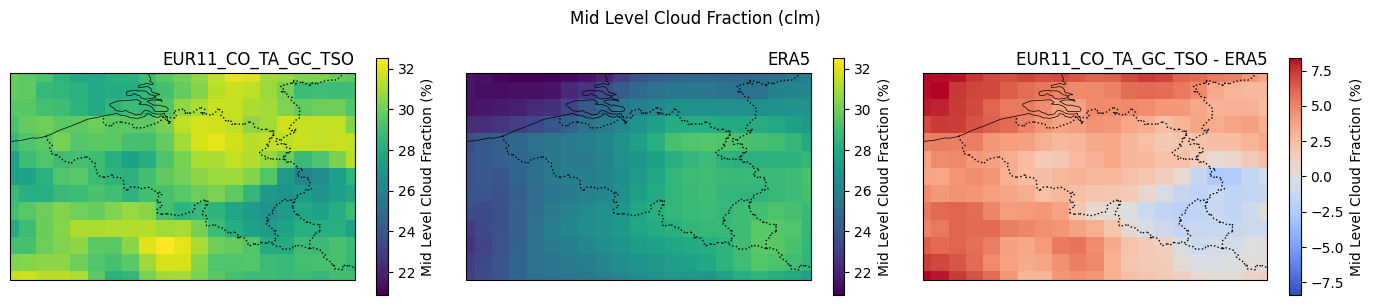

In [15]:
mod_variable = "CLCM"

region = 'belgium'
variable = 'clm'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)


### High  cloud percentage

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/high_cloud_cover/era5-hourly-europe-high_cloud_cover-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['clh']
The following attributes are missing or incorrect for the variable clh:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           (0 - 1)                   %                        
EUR11_CO_TA_GC_TSO


cdi  warning (cdfInqContents): Coordinates variable number can't be assigned!
cdi  warning (cdfInqContents): Coordinates variable surface can't be assigned!


cdo    remapbil: Bilinear weights from curvilinear (446x434) to lonlat (289x163) grid


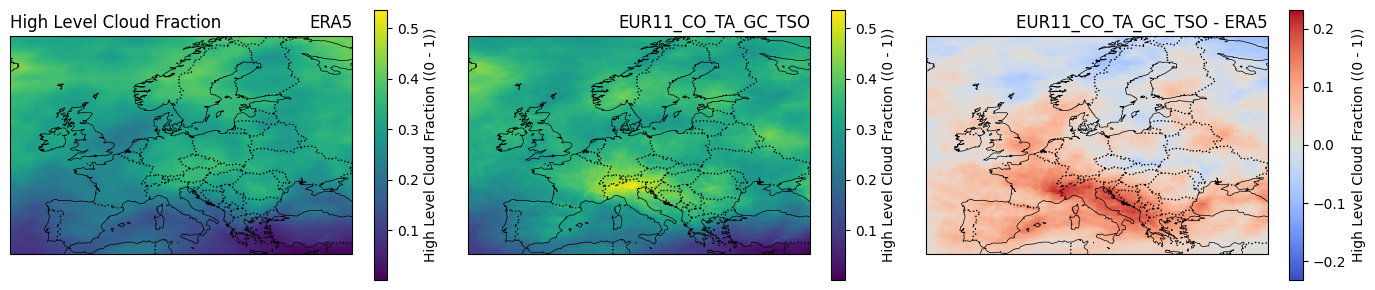

In [ ]:
mod_variable = "CLCH"

region = 'europe'
variable = 'clh'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)


In [16]:
mod_variable = "CLCH"

region = 'belgium'
variable = 'clh'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/high_cloud_cover/era5-hourly-europe-high_cloud_cover-1995.nc


AttributeError: 'DataArray' object has no attribute 'time'

## Mean sea level pressure

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/daily/mean_sea_level_pressure/era5-daily-europe-mean_sea_level_pressure-1995.nc


The file is ValEnsPy CF compliant.
50.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['psl']
Unknown to ValEnsPy: ['time_bnds']
EUR11_CO_TA_GC_TSO
cdo    remapbil: Bilinear weights from curvilinear (446x434) to lonlat (289x163) grid


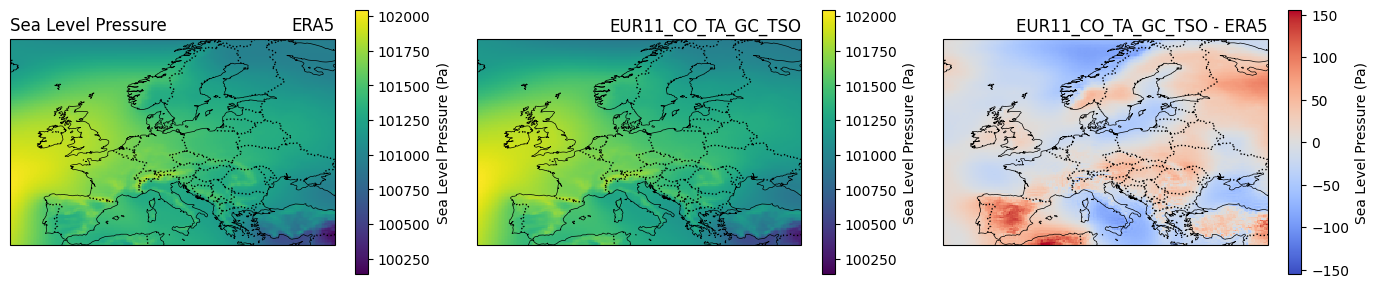

In [ ]:
region = 'europe'
variable = 'psl'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/belgium/daily/mean_sea_level_pressure/era5-daily-belgium-mean_sea_level_pressure-1995.nc
The file is ValEnsPy CF compliant.
50.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['psl']
Unknown to ValEnsPy: ['time_bnds']
EUR11_CO_TA_GC_TSO


cdo    remapbil: Bilinear weights from curvilinear (446x434) to lonlat (41x25) grid


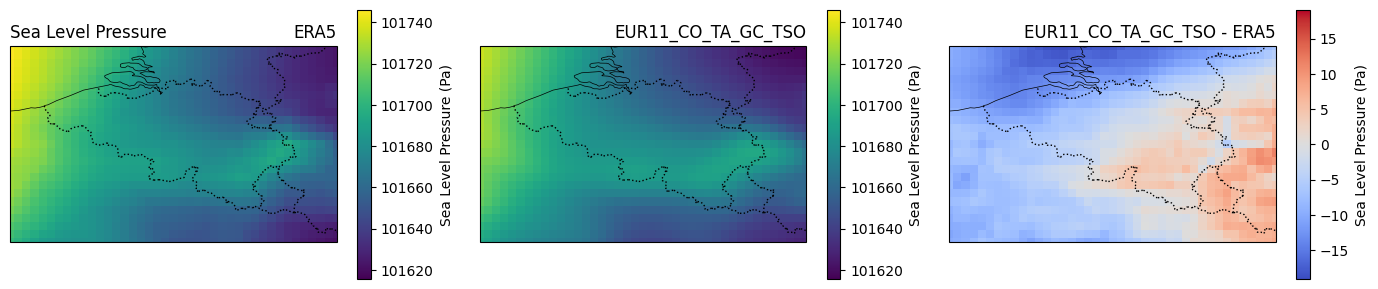

In [ ]:
region = 'belgium'
variable = 'psl'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)

## Radiation and turbulent fluxes

#### latent heat flux

Issue with conversion!!!

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/surface_latent_heat_flux/era5-land-hourly-belgium-surface_latent_heat_flux-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['hfls']
EUR11_CO_TA_GC_TSO
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/LHFL_S/daily/LHFL_S_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['hfls']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']


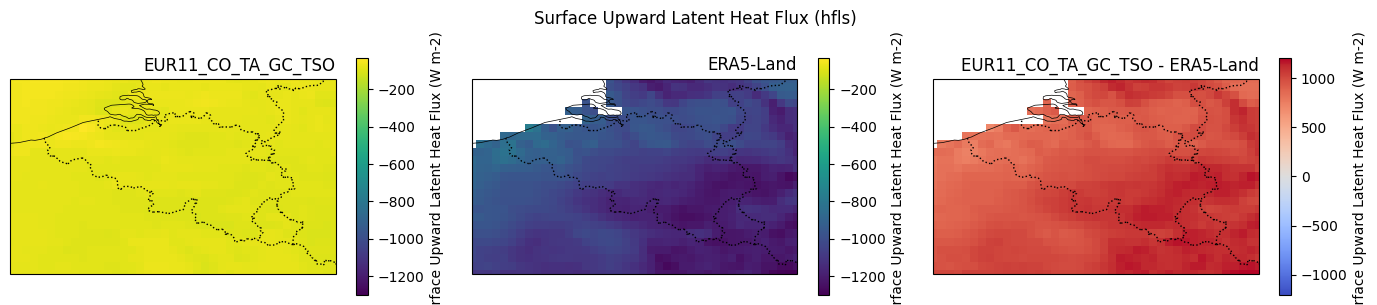

In [15]:
region = 'belgium'
variable = 'hfls'
ref_dataset = "ERA5-Land"
months_to_analyse = [6,7,8]


fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)


#### sensible heat flux

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/surface_sensible_heat_flux/era5-land-hourly-belgium-surface_sensible_heat_flux-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['hfss']
The following attributes are missing or incorrect for the variable hfss:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           J m**-2                   W m-2                    
did unit conversion
EUR11_CO_TA_GC_TSO
cdo    remapbil: Bilinear weights from curvilinear (446x434) to lonlat (41x25) grid


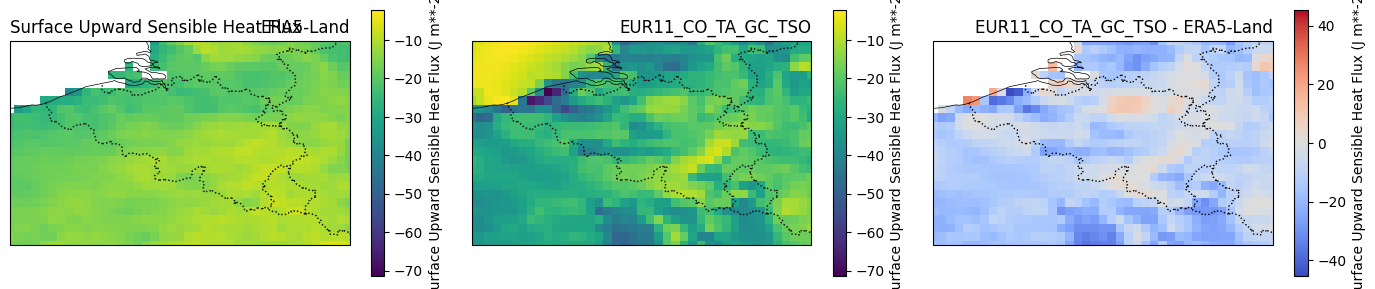

In [ ]:
region = 'belgium'
variable = 'hfss'
ref_dataset = "ERA5-Land"
months_to_analyse = [7,8]

unit_conversion=True # hack for quick fix of ERA5 unit conversion

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region, unit_conversion)


#### SW down surface

In [ ]:
# surface solar radation downwards
variable = 'rsds'

#### LW down surface

In [ ]:
# surface_thermal_radiation_downwards
variable = 'rlds'


#### Incident SW TOA

In [ ]:
variable = 'rsdt'

#### Incident LW TOA

## Hydrometeors
Until conversion from ERA5, only CCLM maps

In [ ]:
variables =  [ 'TQR', 'TQV', 'TQC', 'TQI', 'TQG', 'TQS']